# Detecting grain sizes of NEEM images
***
* Author: Yannick E. Heiser
* Email:  wfg813@alumni.ku.dk
* Last Update:   17th of May 2023
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 40
plt.rcParams['font.size'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['legend.fontsize'] = 30
plt.rcParams['axes.axisbelow'] = True
import sys
import glob
import os
from scipy.ndimage import label, generate_binary_structure, gaussian_filter1d
from skimage import io, color, measure, img_as_float, img_as_uint, img_as_ubyte, exposure, morphology, feature
from skimage.segmentation import clear_border, felzenszwalb, mark_boundaries
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.filters import hessian, frangi, sobel, meijering, sato, threshold_multiotsu, scharr, try_all_threshold, threshold_otsu
from skimage.util import invert
from os.path import join, exists
import os
from scipy.signal import welch, correlate
from scipy.stats import pearsonr, linregress
from scipy.interpolate import PchipInterpolator
from scipy.ndimage import gaussian_filter1d
from PIL import Image
Image.MAX_IMAGE_PIXELS = 2000000000
!{sys.executable} -m pip install xlrd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 3.4 MB/s eta 0:00:00


### 1. Create dataset of gray values

In [2]:
# Resolution: 200px = 1cm
px_to_m = 5e-5
len_std = 0.55*2/px_to_m
NEEM_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/LineScan/NEEM/VisStrat/0_All_Bags_sorted/0_all/"
bag_numbers = np.arange(3642,3688,2)
step_size = 20 #1mm = 20px


gray_df = pd.DataFrame(columns=["depth[m]","gray_value","gray_value_err","bag"])
for bag in bag_numbers:
    print(bag)
    n = 20
    if bag<3656 or bag>3664:
        n = 11
    file_name = "{}_pass{}_1200.bmp".format(bag,n)
    img_path = join(NEEM_path,file_name)
    img = io.imread(img_path)
    img = img[280:-280,800:1500]
    img = np.flip(img.T,axis=1)
    len_img = np.shape(img)[1]
    delta_len = abs(int(len_img/step_size)*step_size-len_std) #length in m of cropped images
    depth_start = round((bag-1)*0.55+delta_len*px_to_m/2,4)
    for ii in range(int(len_img/step_size)):
        x_img = step_size*ii+step_size/2
        depth = round(depth_start+x_img*px_to_m,4)
        img1 = img[:,int(x_img-step_size/2):int(x_img+step_size/2)]
        #for i in np.argwhere(img1==255.): # if wanna take out 255 values
        #    img1[i[0],i[1]] = np.nan
        mean = np.nanmean(img1)
        std = np.nanstd(img1)
        new_df = pd.DataFrame([[depth,mean,std,bag]],columns=["depth[m]","gray_value","gray_value_err","bag"])
        gray_df = pd.concat([gray_df,new_df],ignore_index=True)
gray_df = gray_df.sort_values(by=["depth[m]"])

3642


/tmp/ipykernel_1696/3190245219.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gray_df = pd.concat([gray_df,new_df],ignore_index=True)


3644
3646
3648
3650
3652
3654
3656
3658
3660
3662
3664
3666
3668
3670
3672
3674
3676
3678
3680
3682
3684
3686


In [3]:
# Check data
print(np.argwhere(np.isnan(np.array(gray_df["gray_value"]))))
gray_df.head()

[]


,depth[m],gray_value,gray_value_err,bag
0,2002.5555,38.166500,19.483192,3642
1,2002.5565,34.177929,14.655384,3642
2,2002.5575,31.341357,15.062085,3642
3,2002.5585,29.996500,14.264994,3642
4,2002.5595,26.334571,15.459890,3642


In [4]:
# xLASM import
resolution_mm = {"2": 2}
df_sizes = {}
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/grain_sizes_depth/"

for key in resolution_mm.keys():
    print(key)
    path = file_path + "grain_data_interp_{}mm.csv".format(resolution_mm[key])
    df_sizes[key] = pd.read_csv(path)
df_sizes["2"].head()

2


,depth[m],equivalent_diameter[px],grain_size[px]
0,2002.552,303.608543,2.049157e+06
1,2002.553,312.107969,2.416072e+06
2,2002.554,296.886203,2.266391e+06
3,2002.555,282.890804,2.123016e+06
4,2002.556,328.829942,2.967209e+06


In [5]:
# Plot Linescan with gray values on top
bag = 3658
n = 20
if bag<3656 or bag>3664:
    n = 11
file_name = "{}_pass{}_1200.bmp".format(bag,n)
img_path = join(NEEM_path,file_name)
img = io.imread(img_path)
img = img[280:-280,800:1500]
img = np.flip(img.T,axis=1)
img.shape

(700, 21803)

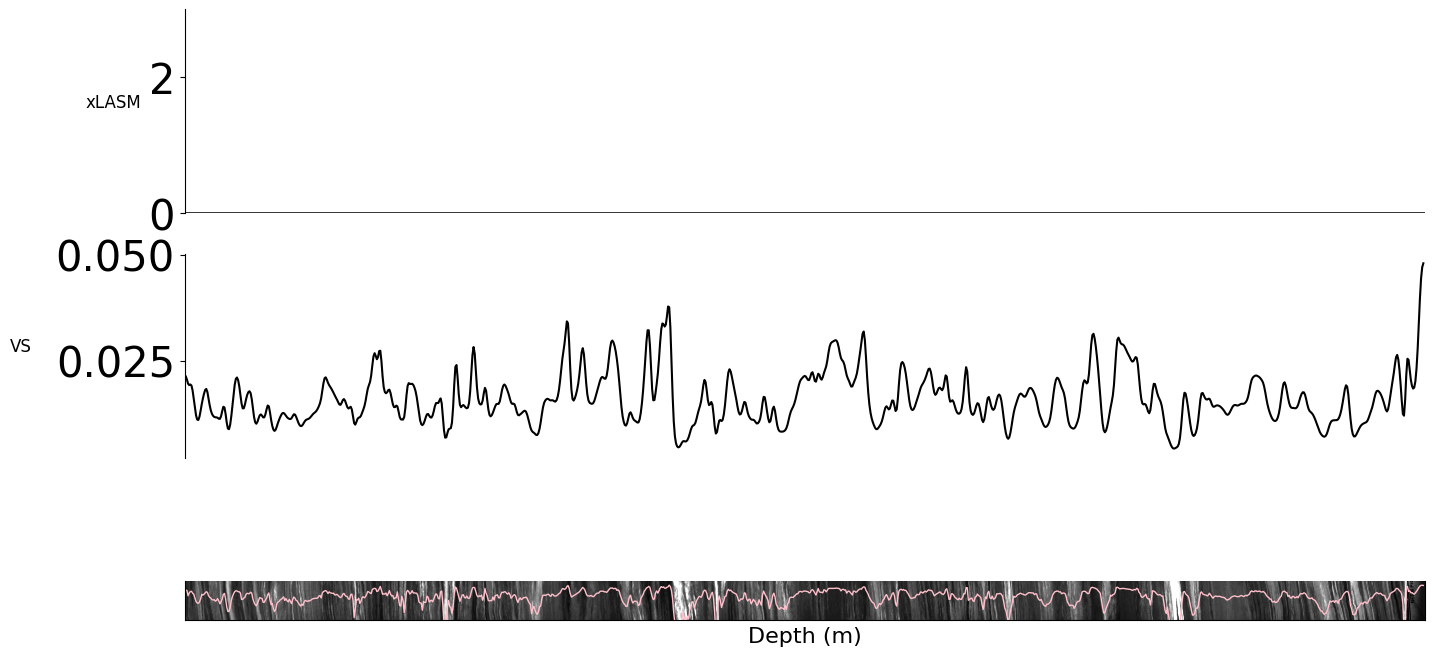

In [6]:

df_gray_slic1 = gray_df[gray_df["depth[m]"]<(3659)*0.55]
df_gray_slic1 = df_gray_slic1[df_gray_slic1["depth[m]"]>(3658-1)*0.55]

fig, ax = plt.subplots(3, 1,figsize=(16,9),sharex=True)

ax[0].plot((df_sizes["2"]["depth[m]"]-(3658-1)*0.55)/px_to_m,gaussian_filter1d(df_sizes["2"]["grain_size[px]"]/5**2*px_to_m**2,1.5),'-',color="black",label="Grain size",alpha=1)
ax[1].plot((df_gray_slic1["depth[m]"]-df_gray_slic1["depth[m]"].iloc[0])/px_to_m,gaussian_filter1d(1/df_gray_slic1["gray_value"],1.5),'-',color="black",label="Grain size",alpha=1)
ax[2].plot((df_gray_slic1["depth[m]"]-df_gray_slic1["depth[m]"].iloc[0])/px_to_m, df_gray_slic1["gray_value"]*4, '-',color="pink",lw=1)
ax[2].imshow(img, cmap="gray")

ax[0].set_ylabel('xLASM',rotation=0,labelpad=25,fontsize=12)
ax[1].set_ylabel('VS',rotation=0,labelpad=25,fontsize=12)
ax[2].set_xlabel("Depth (m)",fontsize=16)

# Remove top and bottom spines from the axes
ax[0].spines['top'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

ax[0].tick_params("x",bottom=False)
ax[1].tick_params("x",bottom=False)
ax[2].tick_params("x",bottom=False)

# axis limits
#ax[1].set_xlim(xmin=0,xmax=0.55*2/px_to_m)
ax[0].set_ylim(ymin=0,ymax=3)
#ax[0].set_yticks([], [])
#ax[1].set_yticks([], [])
#ax[2].set_yticks([], [])
#ax[2].ticklabel_format(axis="x",useOffset=False)
#ax[2].set_xticks([0,0.2/px_to_m,0.4/px_to_m,0.6/px_to_m,0.8/px_to_m,1.0/px_to_m])
#ax[2].set_xticklabels([round(3657*0.55,1),round(3657*0.55+0.2,1),round(3657*0.55+0.4,1),round(3657*0.55+0.6,1),round(3657*0.55+0.8,1),round(3657*0.55+1.,1)])

# add grid
ax[0].grid(which='major', axis='x', linestyle='--')
ax[1].grid(which='major', axis='x', linestyle='--')

ax[2].set_xticks([])
ax[2].set_yticks([])
fig.show()

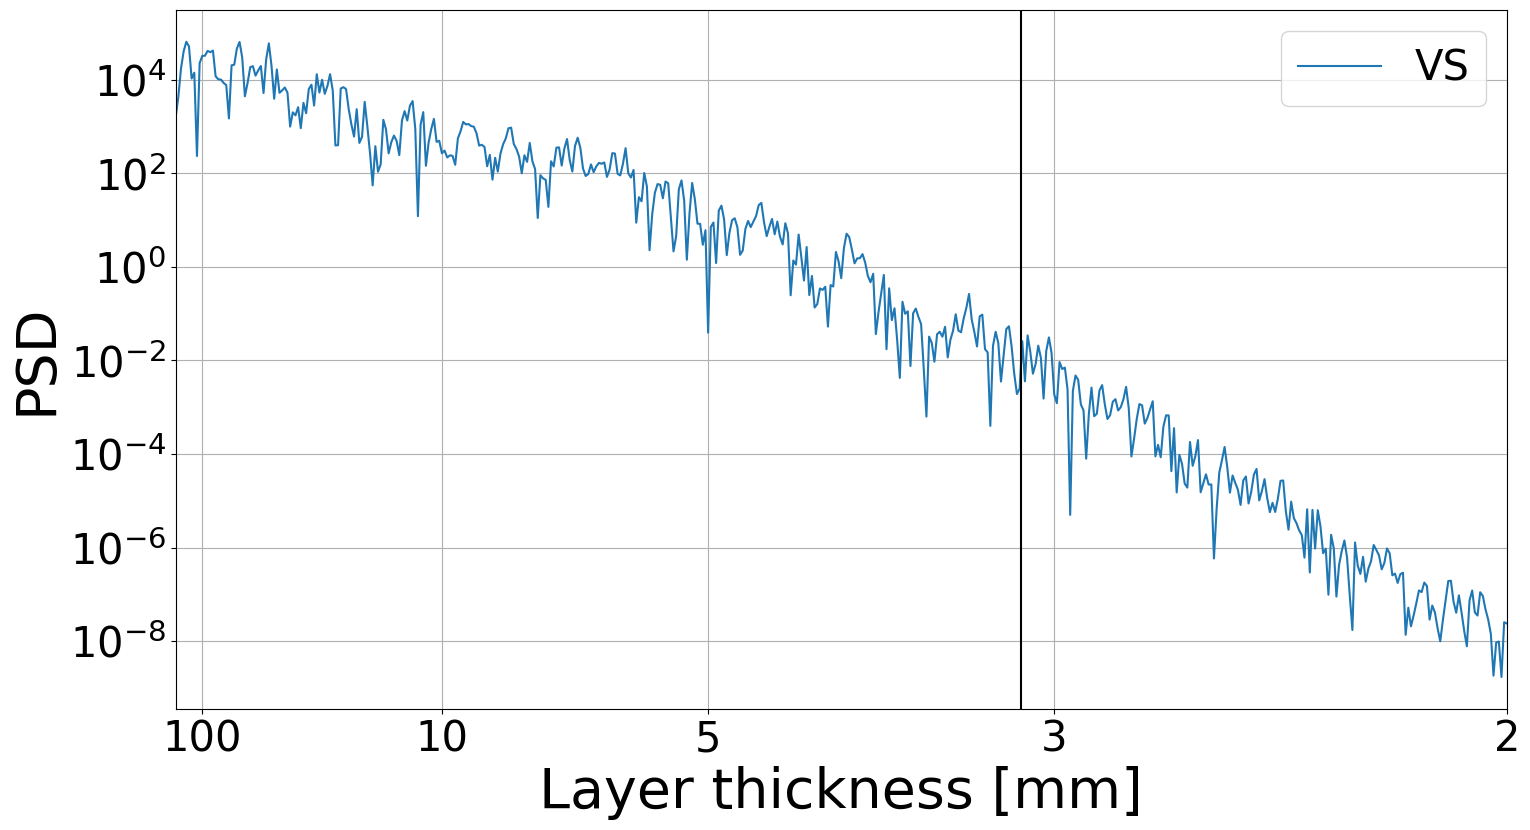

In [7]:
# Plot PSD
fs = 1 # sampling frequency in [1/mm]
fig, ax = plt.subplots(figsize=(16, 9))
f, Pxx = welch(gaussian_filter1d(df_gray_slic1["gray_value"],1.5),fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="VS")
#f, Pxx = welch(df_sizes_stadial["grain_size[px]"]/1000000,fs,nperseg = 1000)
#ax.semilogy(f, Pxx,label="grain size")
ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.vlines(1/3.15,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black")
ax.set_xlim(0.0001,0.5)
ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
ax.set_xlabel('Layer thickness [mm]')
ax.set_ylabel('PSD')
ax.legend()
ax.grid()
fig.tight_layout()
#fig.savefig("Plots/24_VS_PSD_GS20.png",dpi=100)
fig.show()

### 2. Interpolate data 

In [8]:
# Interpolate missing data

df_gray_interp = pd.DataFrame()

depth_min = round(gray_df["depth[m]"].iloc[0],3)
depth_max = round(gray_df["depth[m]"].iloc[-1],3)

# make equidistant dataset 
depth_new = np.arange(depth_min,depth_max,0.001)
cs_gray = PchipInterpolator(gray_df["depth[m]"], gray_df["gray_value"])
# Fehlerfortpflanzung bei Interpolation??
cs_gray_err = PchipInterpolator(gray_df["depth[m]"], gray_df["gray_value_err"])
gray_new = cs_gray(depth_new)
greay_err_new = cs_gray_err(depth_new)
df_gray_interp["depth[m]"] = np.round(depth_new,3)
df_gray_interp["gray_value"] = gray_new
df_gray_interp["gray_value_err"] = greay_err_new
df_gray_interp.head()

,depth[m],gray_value,gray_value_err
0,2002.556,36.016062,16.138655
1,2002.557,32.573303,14.858734
2,2002.558,30.686754,14.663540
3,2002.559,28.235302,14.862442
4,2002.560,25.326288,13.658646


In [9]:
# Save interpolated gray values as csv
#df_gray_interp.to_csv("/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/Linescan_gray_values_interpolated/gray_interpolated.csv",index=False)

### 3. Plot Linescan data and PSD 

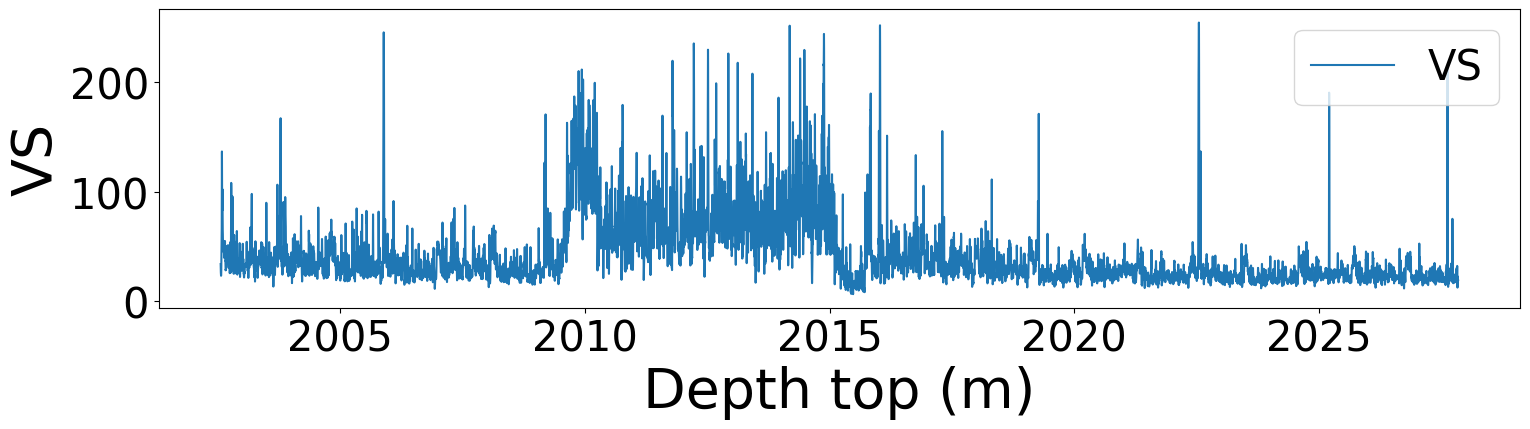

In [10]:
# Plot interpolated data
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(df_gray_interp["depth[m]"], gaussian_filter1d(df_gray_interp["gray_value"],1.5), '-',label="VS",alpha=1)
ax.set_xlabel('Depth top (m)')
ax.set_ylabel('VS')
ax.legend()
plt.tight_layout()
plt.show()

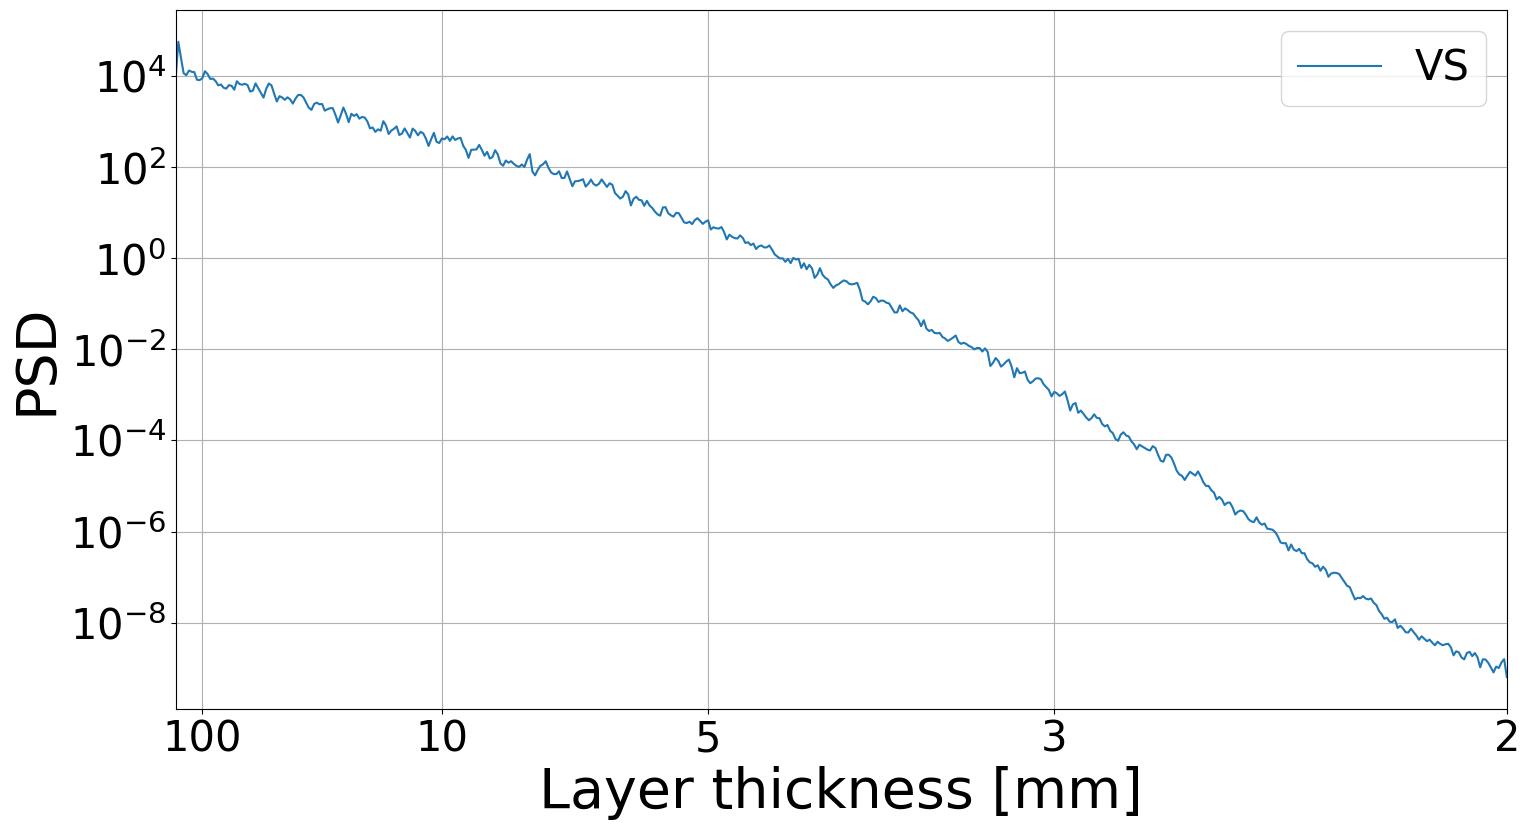

In [11]:
# Plot PSD
fs = 1 # sampling frequency in [1/mm]
fig, ax = plt.subplots(figsize=(16, 9))
f, Pxx = welch(gaussian_filter1d(df_gray_interp["gray_value"],1.5),fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="VS")
ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
#ax.set_ylim(1e-8,1e12)
#ax.vlines(1/layer_thickness/1000,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black")
ax.set_xlim(0.0001,0.5)
ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
ax.set_xlabel('Layer thickness [mm]')
ax.set_ylabel('PSD')
ax.legend()
ax.grid()
fig.tight_layout()
#fig.savefig("Plots/17_CFA_PSD_GS20.png",dpi=100)
fig.show()

In [12]:
# xLASM PSD
resolution_mm = {"2": 2,"5": 5, "10": 10}
df_sizes = {}
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/grain_sizes_depth/"

for key in resolution_mm.keys():
    print(key)
    path = file_path + "grain_data_interp_{}mm.csv".format(resolution_mm[key])
    df_sizes[key] = pd.read_csv(path)
df_sizes["5"].head()

2
5
10


,depth[m],equivalent_diameter[px],grain_size[px]
0,2002.552,271.492211,1.908195e+06
1,2002.553,298.352598,2.234907e+06
2,2002.554,306.390432,2.428203e+06
3,2002.555,315.135875,2.661054e+06
4,2002.556,320.079678,2.766849e+06


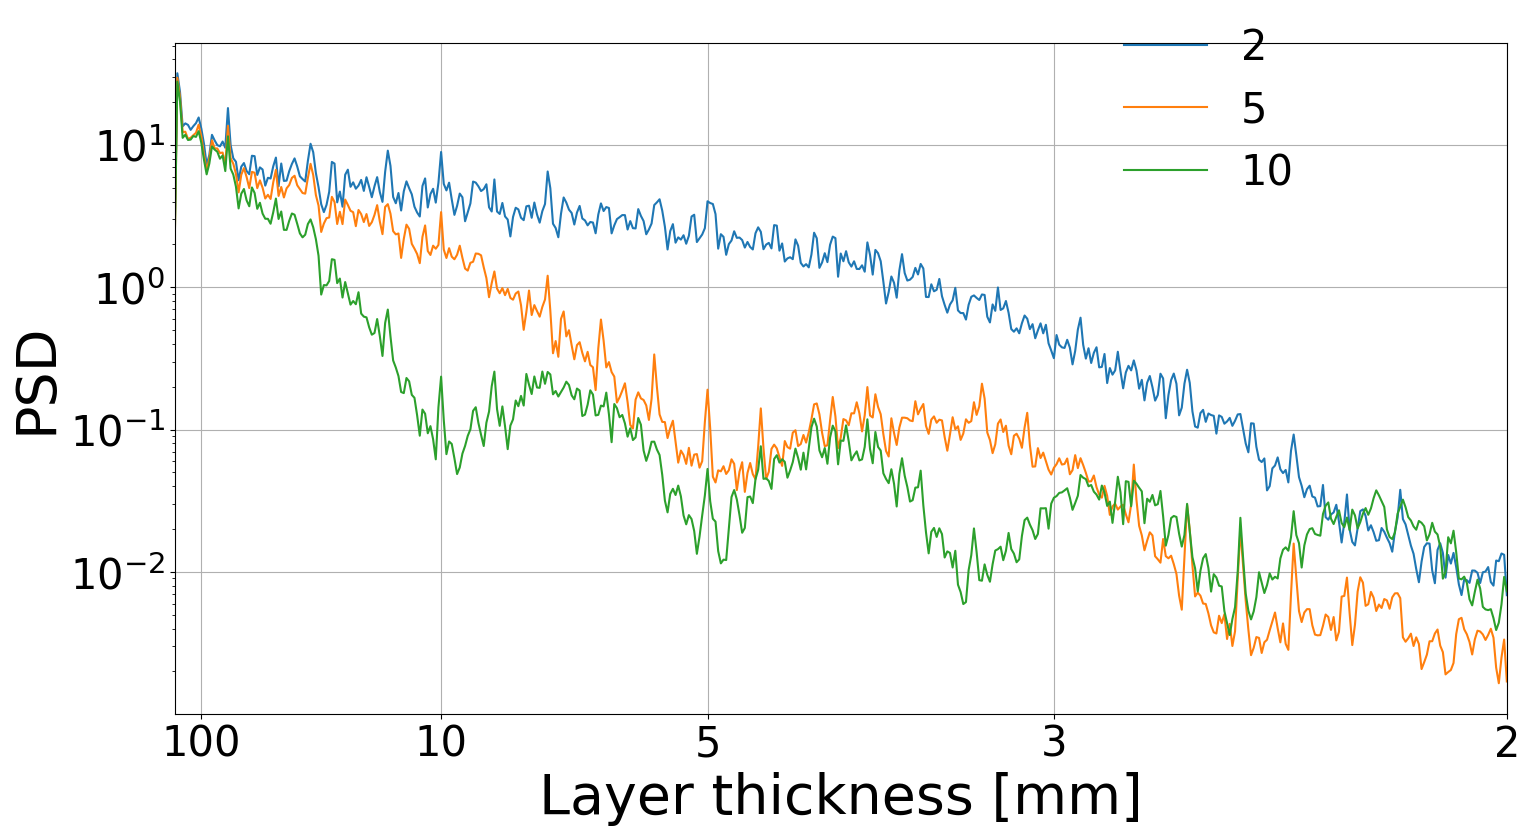

In [13]:
# Plot PSD of stadial xLASM
fs = 1 # sampling frequency in [1/mm]
fig, ax = plt.subplots(figsize=(16, 9))
for res in df_sizes.keys():
    f, Pxx = welch(df_sizes[res]["grain_size[px]"]/1000000,fs,nperseg = 1000)
    ax.semilogy(f, Pxx,label=res)
ax.set_xlim(0.0001,0.5)
ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
ax.set_xlabel('Layer thickness [mm]')
ax.set_ylabel('PSD')
ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
            borderaxespad=0, frameon=False)
ax.grid()
fig.tight_layout()
fig.show()

### GS-20

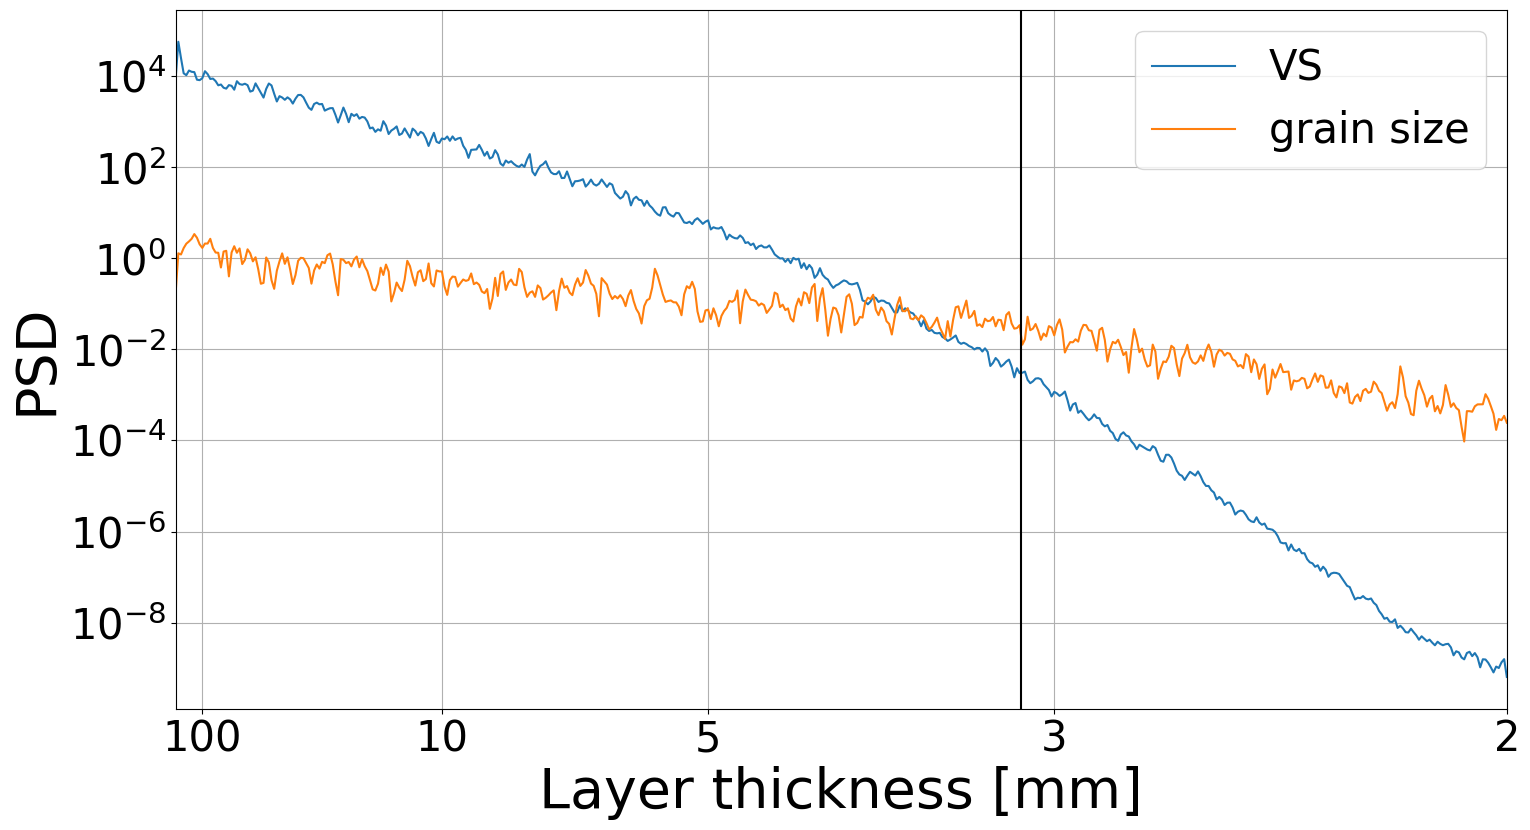

In [14]:
df_gray_interp_stadial = df_gray_interp[df_gray_interp["depth[m]"]<(3659)*0.55]
df_gray_interp_stadial = df_gray_interp_stadial[df_gray_interp_stadial["depth[m]"]>(3655-1)*0.55]
df_sizes_stadial = df_sizes["2"][df_sizes["2"]["depth[m]"]<(3659)*0.55]
df_sizes_stadial = df_sizes_stadial[df_sizes_stadial["depth[m]"]>(3655-1)*0.55]

# Plot PSD
fs = 1 # sampling frequency in [1/mm]
fig, ax = plt.subplots(figsize=(16, 9))
f, Pxx = welch(gaussian_filter1d(df_gray_interp["gray_value"],1.5),fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="VS")
f, Pxx = welch(df_sizes_stadial["grain_size[px]"]/1000000,fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="grain size")
ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.vlines(1/3.15,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black")
ax.set_xlim(0.0001,0.5)
ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
ax.set_xlabel('Layer thickness [mm]')
ax.set_ylabel('PSD')
ax.legend()
ax.grid()
fig.tight_layout()
fig.savefig("Plots/24_VS_PSD_GS20.png",dpi=100)
fig.show()

### GI-19.2

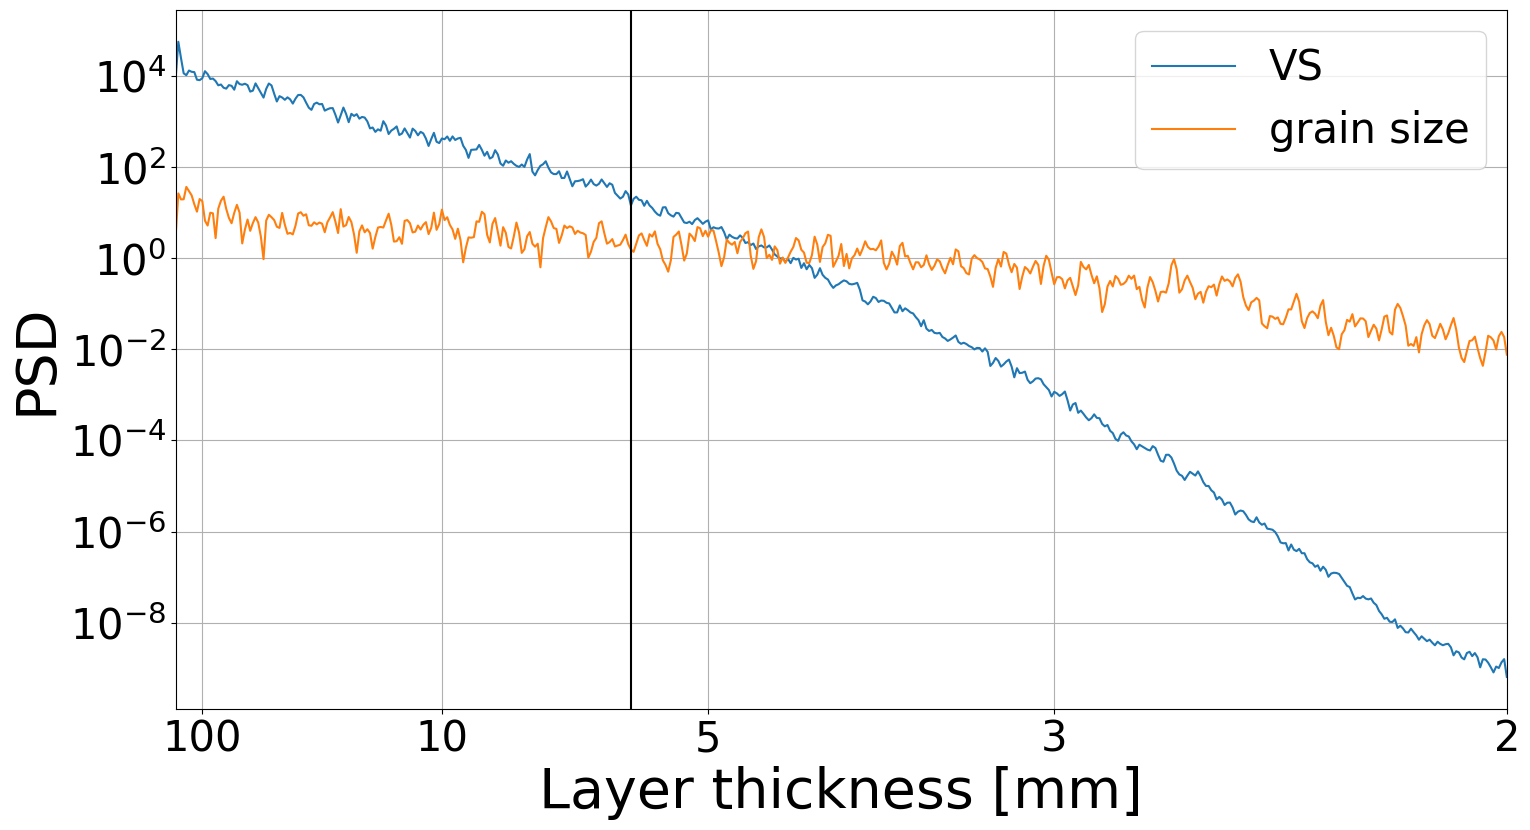

In [15]:
df_gray_interp_stadial = df_gray_interp[df_gray_interp["depth[m]"]<(3647)*0.55]
df_gray_interp_stadial = df_gray_interp_stadial[df_gray_interp_stadial["depth[m]"]>(3642-1)*0.55]
df_sizes_stadial = df_sizes["2"][df_sizes["2"]["depth[m]"]<(3647)*0.55]
df_sizes_stadial = df_sizes_stadial[df_sizes_stadial["depth[m]"]>(3642-1)*0.55]

# Plot PSD
fs = 1 # sampling frequency in [1/mm]
fig, ax = plt.subplots(figsize=(16, 9))
f, Pxx = welch(gaussian_filter1d(df_gray_interp["gray_value"],1.5),fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="VS")
f, Pxx = welch(df_sizes_stadial["grain_size[px]"]/1000000,fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="grain size")
ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.vlines(1/5.85,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black")
ax.set_xlim(0.0001,0.5)
ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
ax.set_xlabel('Layer thickness [mm]')
ax.set_ylabel('PSD')
ax.legend()
ax.grid()
fig.tight_layout()
fig.savefig("Plots/24_VS_PSD_GI19.2.png",dpi=100)
fig.show()

### GI-20

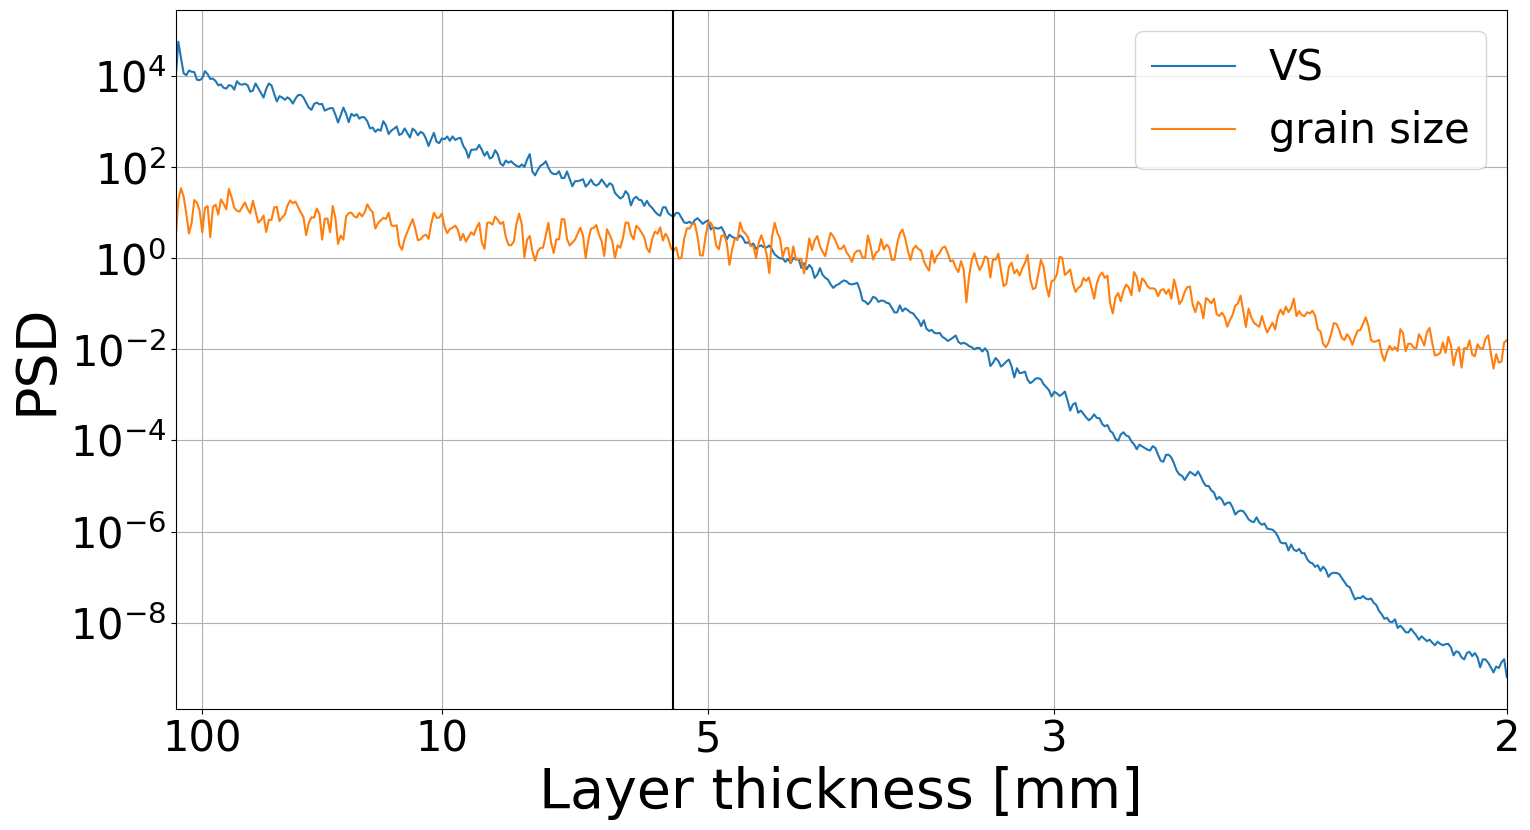

In [16]:
df_gray_interp_stadial = df_gray_interp[df_gray_interp["depth[m]"]<(3671)*0.55]
df_gray_interp_stadial = df_gray_interp_stadial[df_gray_interp_stadial["depth[m]"]>(3667-1)*0.55]
df_sizes_stadial = df_sizes["2"][df_sizes["2"]["depth[m]"]<(3671)*0.55]
df_sizes_stadial = df_sizes_stadial[df_sizes_stadial["depth[m]"]>(3667-1)*0.55]

# Plot PSD
fs = 1 # sampling frequency in [1/mm]
fig, ax = plt.subplots(figsize=(16, 9))
f, Pxx = welch(gaussian_filter1d(df_gray_interp["gray_value"],1.5),fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="VS")
f, Pxx = welch(df_sizes_stadial["grain_size[px]"]/1000000,fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="grain size")
ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.vlines(1/5.35,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black")
ax.set_xlim(0.0001,0.5)
ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
ax.set_xlabel('Layer thickness [mm]')
ax.set_ylabel('PSD')
ax.legend()
ax.grid()
fig.tight_layout()
fig.savefig("Plots/24_VS_PSD_GI20.png",dpi=100)
fig.show()

### All bags

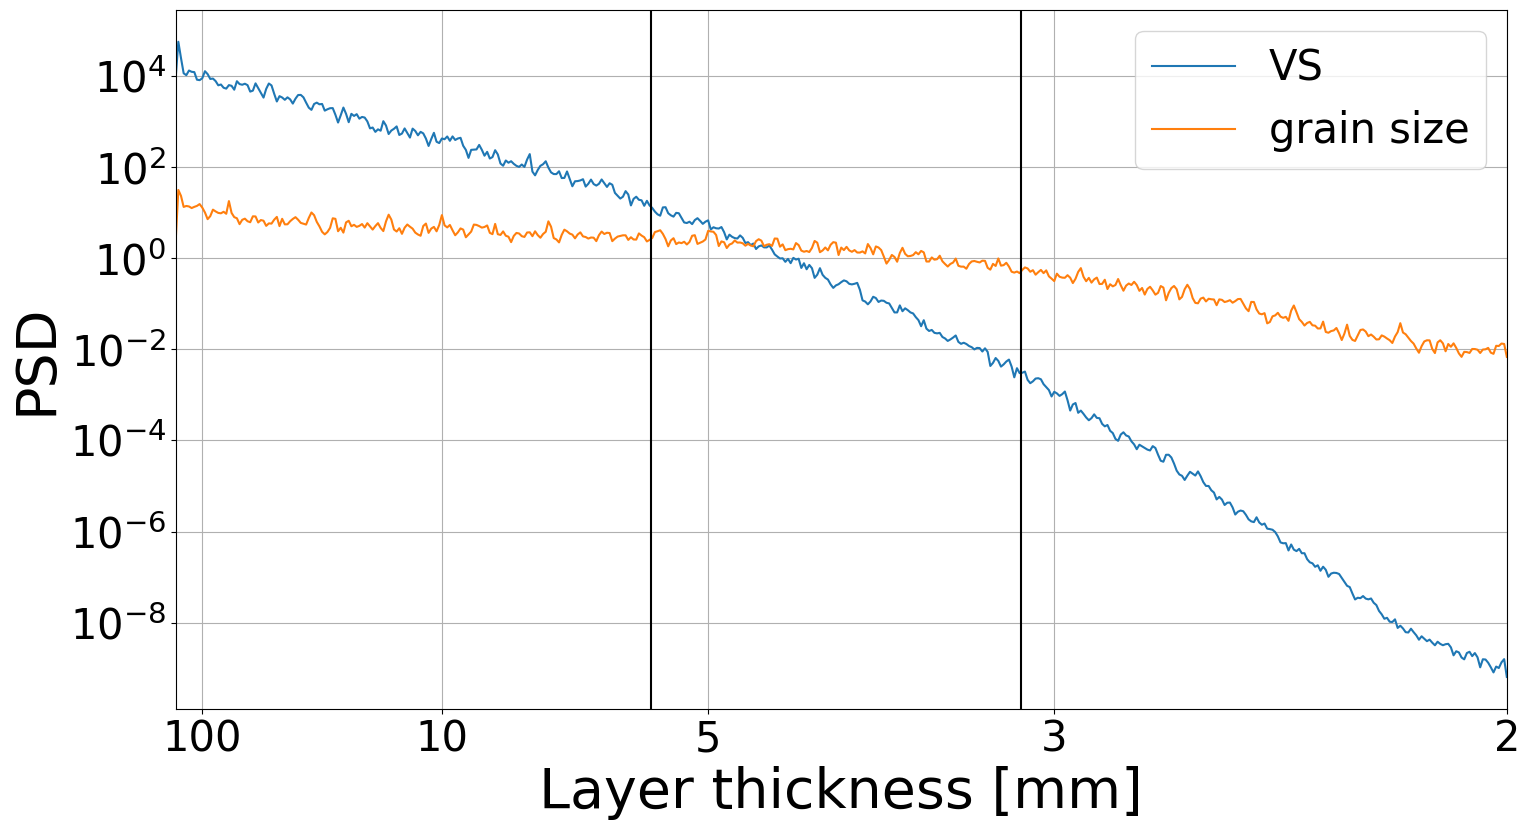

In [17]:
df_gray_interp_stadial = df_gray_interp
df_sizes_stadial = df_sizes["2"]

# Plot PSD
fs = 1 # sampling frequency in [1/mm]
fig, ax = plt.subplots(figsize=(16, 9))
f, Pxx = welch(gaussian_filter1d(df_gray_interp["gray_value"],1.5),fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="VS")
f, Pxx = welch(df_sizes_stadial["grain_size[px]"]/1000000,fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="grain size")
ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.vlines(1/3.15,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black")
ax.vlines(1/5.6,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black")
ax.set_xlim(0.0001,0.5)
ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
ax.set_xlabel('Layer thickness [mm]')
ax.set_ylabel('PSD')
ax.legend()
ax.grid()
fig.tight_layout()
fig.savefig("Plots/24_VS_PSD.png",dpi=100)
fig.show()

### 4. Correlation zu xLASM

In [18]:
# Cut Linescan data down to same data points
indices = np.array([])
for i in range(len(df_sizes["2"])):
    idx = np.argwhere(np.array(np.round(df_gray_interp["depth[m]"],3))==np.round(df_sizes["2"]["depth[m]"].iloc[i],3))
    indices = np.append(indices,idx)
print(len(indices))
df_gray_interp_slice = df_gray_interp.iloc[indices]
df_gray_interp_slice.head()

19701


,depth[m],gray_value,gray_value_err
0,2002.556,36.016062,16.138655
1,2002.557,32.573303,14.858734
2,2002.558,30.686754,14.663540
3,2002.559,28.235302,14.862442
4,2002.560,25.326288,13.658646


In [19]:
# Remove first 4 data points from xLASM so both have same length
df_sizes1 = df_sizes["2"].copy()
df_sizes1 = df_sizes1.drop([0,1,2,3])
df_sizes1.head()

,depth[m],equivalent_diameter[px],grain_size[px]
4,2002.556,328.829942,2.967209e+06
5,2002.557,358.881684,3.573857e+06
6,2002.558,311.979197,2.615748e+06
7,2002.559,321.248194,2.733976e+06
8,2002.560,329.718820,3.087040e+06


In [20]:
df_sizes1_stadial = df_sizes1[df_sizes1["depth[m]"]>(3656-1)*0.55]
df_sizes1_stadial = df_sizes1_stadial[df_sizes1_stadial["depth[m]"]<(3665)*0.55]

df_sizes1_interstadial1 = df_sizes1[df_sizes1["depth[m]"]<(3656-1)*0.55]
df_sizes1_interstadial2 = df_sizes1[df_sizes1["depth[m]"]>(3666-1)*0.55]
df_sizes1_interstadial = pd.concat((df_sizes1_interstadial1,df_sizes1_interstadial2))
print(len(df_sizes1_interstadial))

df_gray_stadial = df_gray_interp_slice[df_gray_interp_slice["depth[m]"]>(3656-1)*0.55]
df_gray_stadial = df_gray_stadial[df_gray_stadial["depth[m]"]<(3665)*0.55]

df_gray_interstadial1 = df_gray_interp_slice[df_gray_interp_slice["depth[m]"]<(3656-1)*0.55]
df_gray_interstadial2 = df_gray_interp_slice[df_gray_interp_slice["depth[m]"]>(3666-1)*0.55]
df_gray_interstadial = pd.concat((df_gray_interstadial1,df_gray_interstadial2))
print(len(df_gray_interstadial))

14767
14767


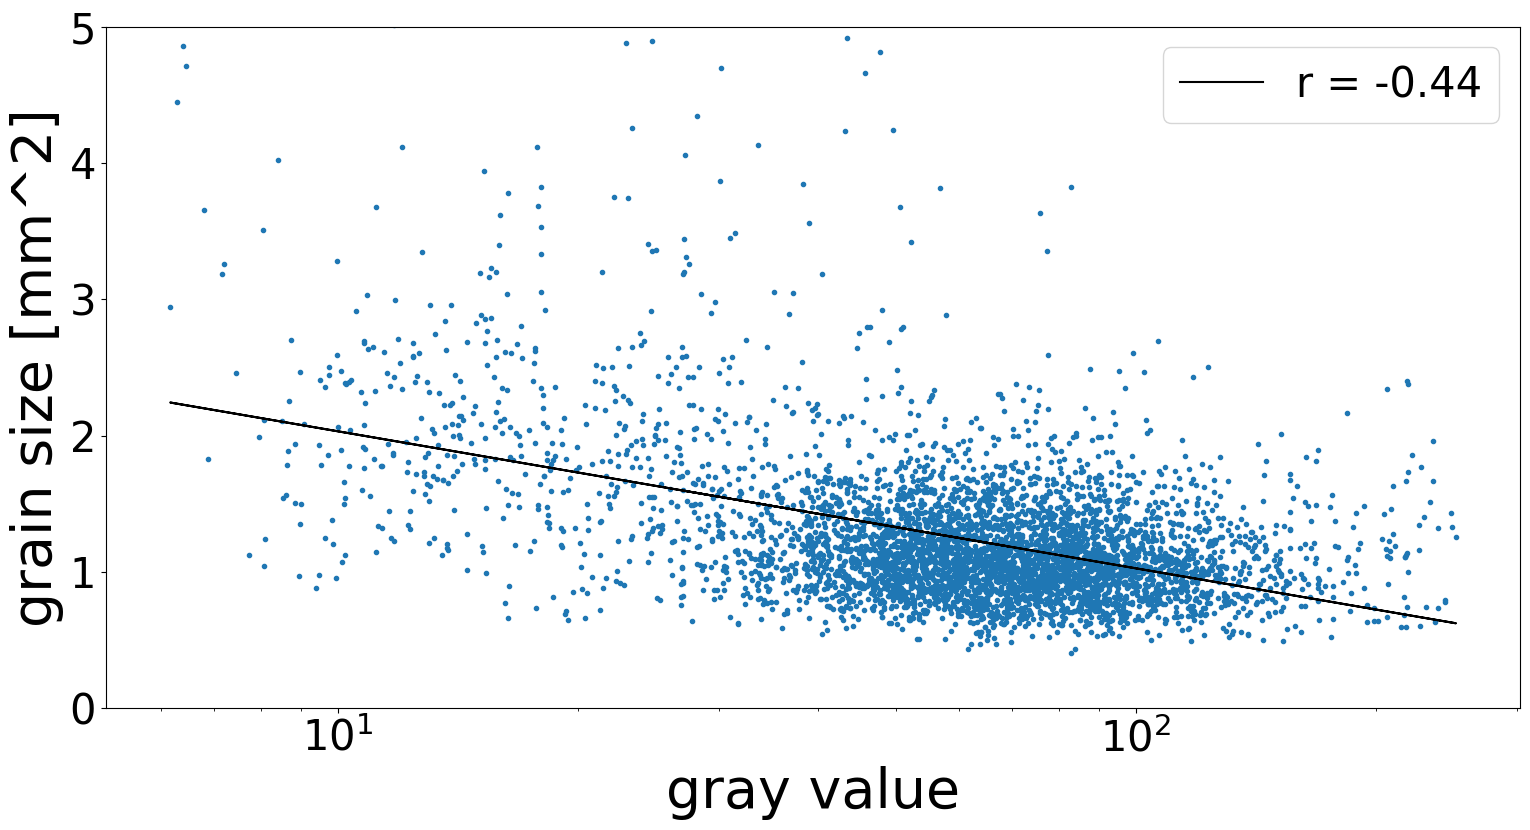

In [21]:
# stadial
corr = linregress(np.log(gaussian_filter1d(df_gray_stadial["gray_value"],1.5)),df_sizes1_stadial["grain_size[px]"]/1000000)

fig, ax = plt.subplots(figsize=(16, 9))
ax.semilogx(gaussian_filter1d(df_gray_stadial["gray_value"],1.5),df_sizes1_stadial["grain_size[px]"]/1000000,".")
ax.semilogx(gaussian_filter1d(df_gray_stadial["gray_value"],1.5),corr.intercept+corr.slope*np.log(gaussian_filter1d(df_gray_stadial["gray_value"],1.5)),"-",color="black",label="r = {}".format(round(corr.rvalue,2)))
ax.set_ylabel("grain size [mm^2]")
ax.set_xlabel("gray value")
#ax.set_title("Correlation grain size (xLASM) and gray_value (Linescan)")
ax.set_ylim(0,5)
ax.legend()
fig.tight_layout()
fig.savefig("Plots/24_VS_corr_high_stadial.png",dpi=100)
fig.show()

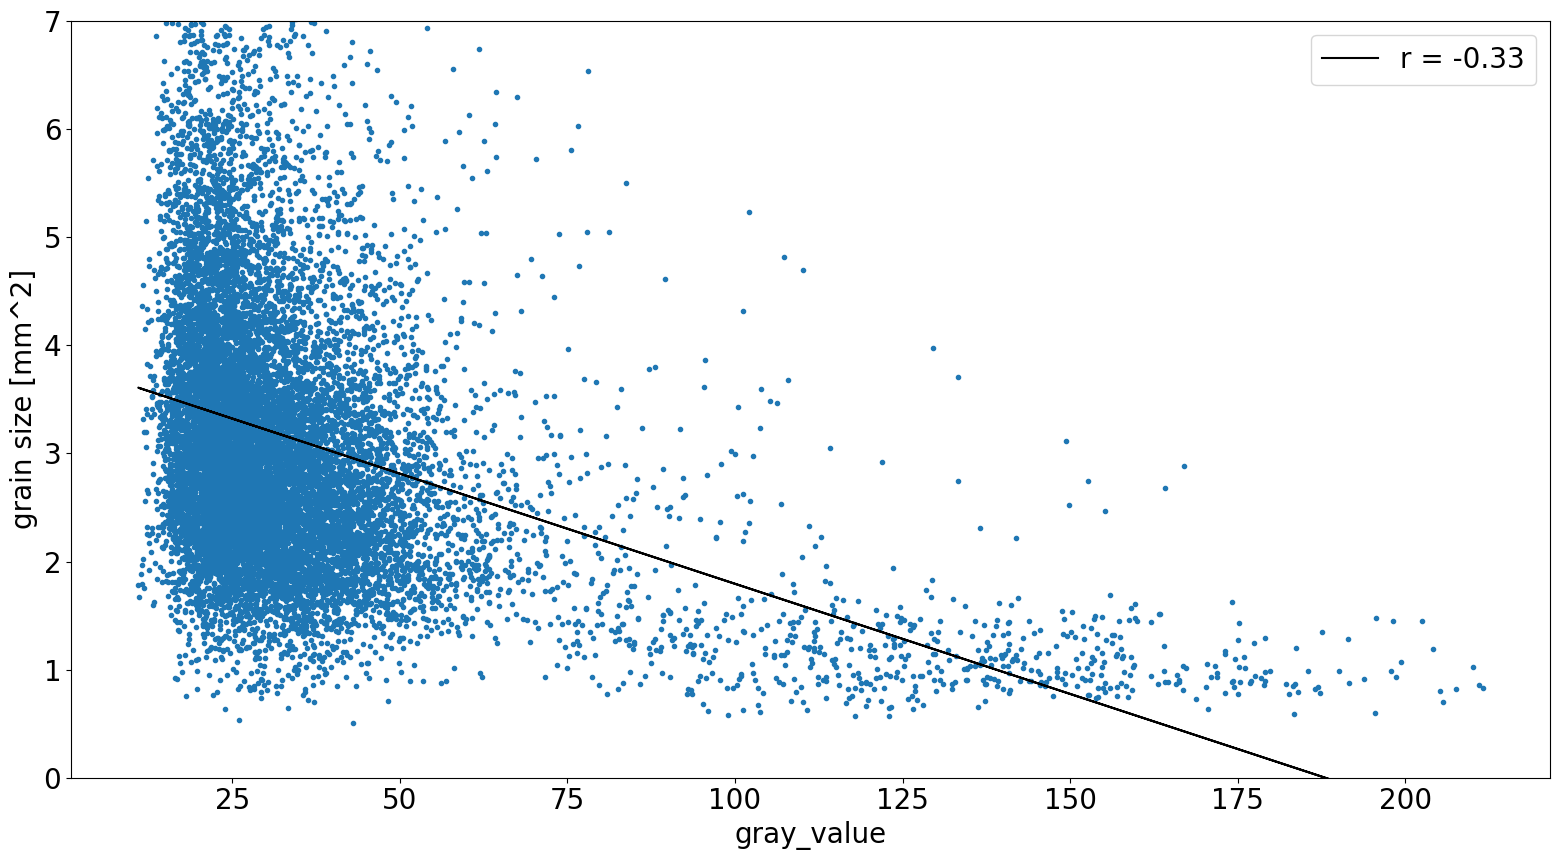

In [27]:
# interstadial
corr = linregress(gaussian_filter1d(df_gray_interstadial["gray_value"],1.5),df_sizes1_interstadial["grain_size[px]"]/1000000)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(gaussian_filter1d(df_gray_interstadial["gray_value"],1.5),df_sizes1_interstadial["grain_size[px]"]/1000000,".")
ax.plot(gaussian_filter1d(df_gray_interstadial["gray_value"],1.5),corr.intercept+corr.slope*gaussian_filter1d(df_gray_interstadial["gray_value"],1.5),"-",color="black",label="r = {}".format(round(corr.rvalue,2)))
ax.set_ylabel("grain size [mm^2]")
ax.set_xlabel("gray_value")
#ax.set_title("Correlation grain size (xLASM) and gray_value (Linescan)")
ax.set_ylim(0,7)
ax.legend()
fig.tight_layout()
fig.savefig("Plots/24_VS_corr_high_interstadial.png",dpi=100)
fig.show()

In [33]:
# Only one image from linescan
df_sizes1_stadial = df_sizes1[df_sizes1["depth[m]"]>(3656-1)*0.55]
df_sizes1_stadial = df_sizes1_stadial[df_sizes1_stadial["depth[m]"]<(3657)*0.55]


df_gray_stadial = df_gray_interp_slice[df_gray_interp_slice["depth[m]"]>(3656-1)*0.55]
df_gray_stadial = df_gray_stadial[df_gray_stadial["depth[m]"]<(3657)*0.55]

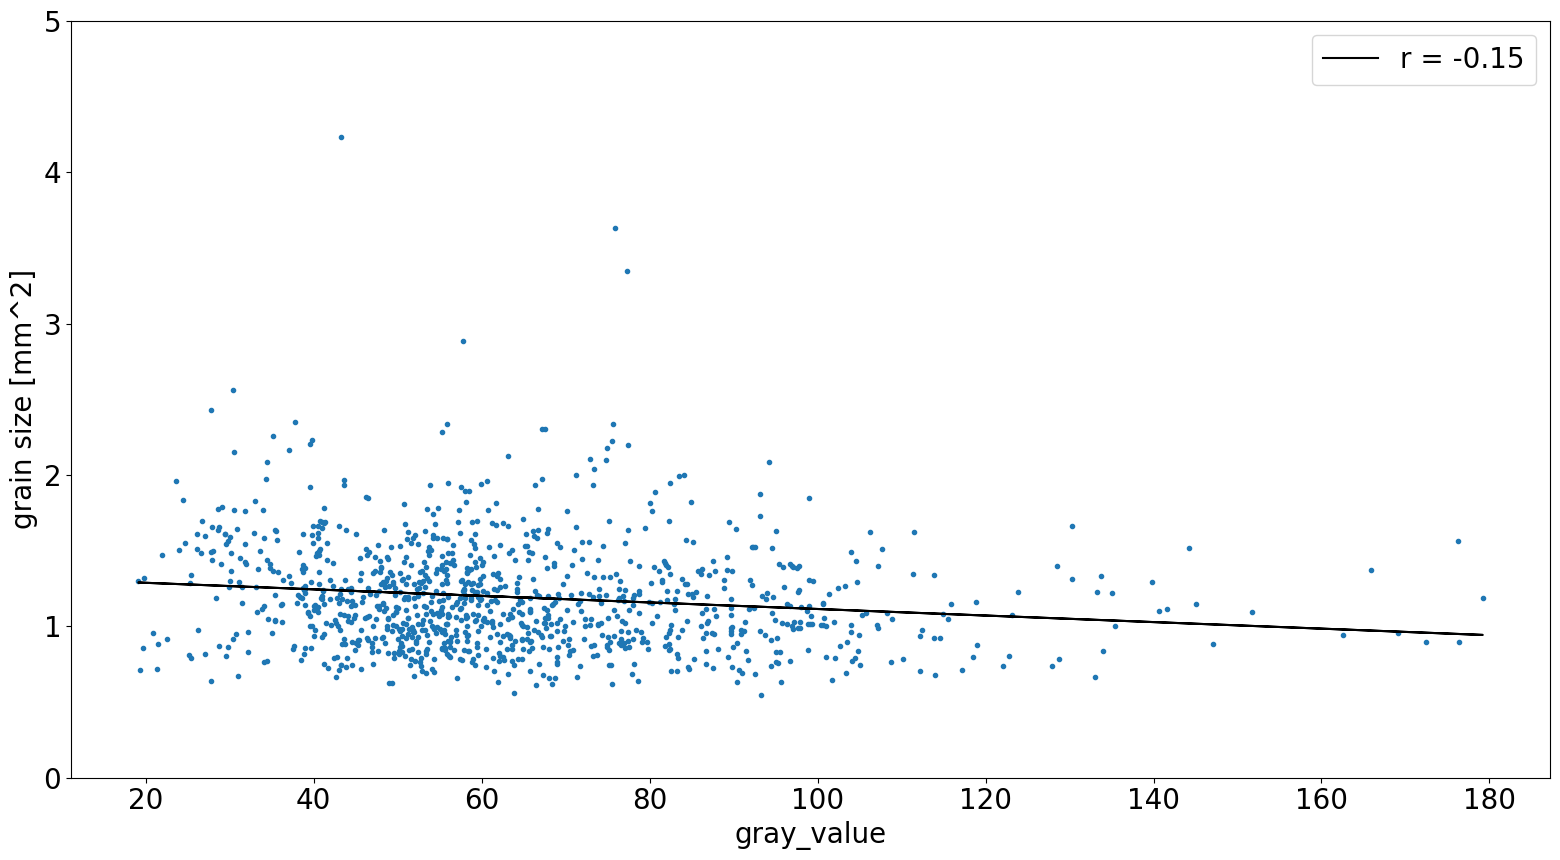

In [34]:
# stadial
corr = linregress(gaussian_filter1d(df_gray_stadial["gray_value"],1.5),df_sizes1_stadial["grain_size[px]"]/1000000)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(gaussian_filter1d(df_gray_stadial["gray_value"],1.5),df_sizes1_stadial["grain_size[px]"]/1000000,".")
ax.plot(gaussian_filter1d(df_gray_stadial["gray_value"],1.5),corr.intercept+corr.slope*gaussian_filter1d(df_gray_stadial["gray_value"],1.5),"-",color="black",label="r = {}".format(round(corr.rvalue,2)))
ax.set_ylabel("grain size [mm^2]")
ax.set_xlabel("gray_value")
#ax.set_title("Correlation grain size (xLASM) and gray_value (Linescan)")
ax.set_ylim(0,5)
ax.legend()
fig.tight_layout()
fig.savefig("Plots/24_VS_corr_high_stadial.png",dpi=100)
fig.show()

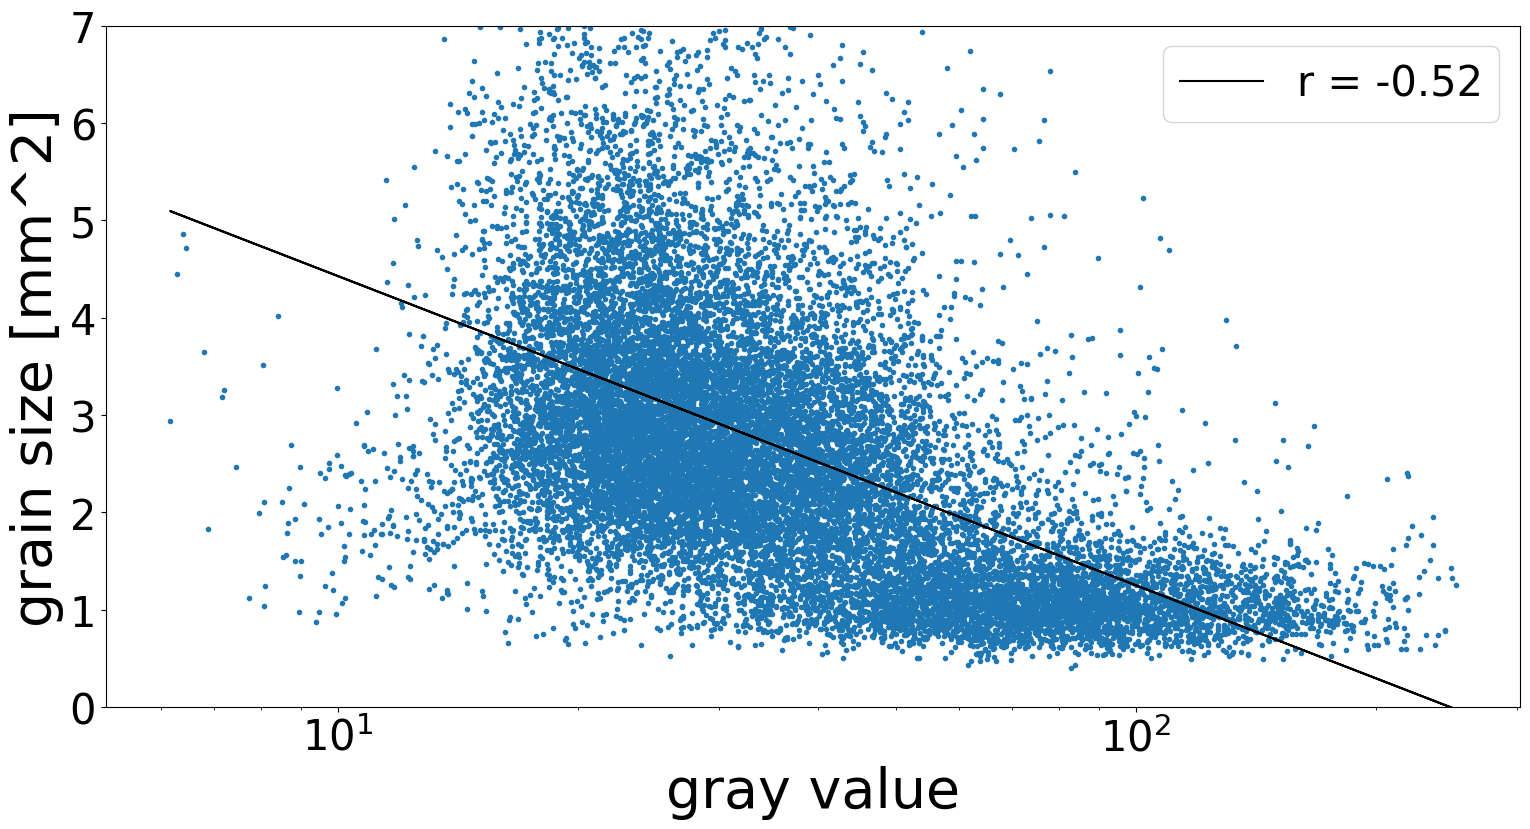

In [25]:
# All data (stadial + interstadial)
corr = linregress(np.log(gaussian_filter1d(df_gray_interp_slice["gray_value"],1.5)),df_sizes1["grain_size[px]"]/1000000)

fig, ax = plt.subplots(figsize=(16, 9))
ax.semilogx(gaussian_filter1d(df_gray_interp_slice["gray_value"],1.5),df_sizes1["grain_size[px]"]/1000000,".")
ax.semilogx(gaussian_filter1d(df_gray_interp_slice["gray_value"],1.5),corr.intercept+corr.slope*np.log(gaussian_filter1d(df_gray_interp_slice["gray_value"],1.5)),"-",color="black",label="r = {}".format(round(corr.rvalue,2)))
ax.set_ylabel("grain size [mm^2]")
ax.set_xlabel("gray value")
#ax.set_title("Correlation grain size (xLASM) and gray_value (Linescan)")
ax.set_ylim(0,7)
ax.legend()
fig.tight_layout()
fig.savefig("Plots/24_VS_corr_high.png",dpi=100)
fig.show()